In [37]:
#Imports
import math
import itertools
import operator
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import scipy.signal as ss
from matplotlib import rc
from astropy import modeling
from astropy.modeling import models, fitting
from photutils.isophote import EllipseGeometry
from photutils import EllipticalAperture
from photutils.isophote import Ellipse
from photutils.isophote import build_ellipse_model

#Formatting
plt.rc('font', family='serif')
plt.rc('xtick', labelsize='medium')
plt.rc('ytick', labelsize='medium')

In [38]:
#Red. Chi Sq. goodness of fit
def reduced_chi_square(fit, x, y, N, n_free):
    '''
    fit (array) values for the fit
    x,y,yerr (arrays) data
    N total number of points
    n_free number of parameters we are fitting
    '''
    return 1.0/(N-n_free)*sum(((fit - y)/np.sqrt(np.abs(y))**2))

In [39]:
#Load npy array & subband
file = '../GBT_B.dm348.9.npy'
npy = np.load(file)

#Array properties
bandwidth = 400 #MHz
centfreq = 800 #MHz
file_duration = 83.33 #ms

#Confirm array size
print('Array shape: ', npy.shape)

Array shape:  (1024, 2048)


In [40]:
#Subband Array
bw = float(bandwidth) #MHz
cfreq = float(centfreq) #MHz

tres = file_duration / npy.shape[1]
print('Raw Time Resolution (microsec): ', tres*1e3)
nchan = npy.shape[0]
fres = bw / nchan
print('Raw Frequency Resolution (kHz): ', fres*1e3)

#Sub-band data
subfac = 8
sub = np.nanmean(npy.reshape(-1, subfac, npy.shape[1]), axis=1)
subts = sub.sum(0) / np.max(sub.sum(0))
subsp = sub.sum(1) / np.max(sub.sum(1))
subchan = nchan / subfac
subfres = bw / subchan
print('Sub Frequency Resolution (kHz): ', subfres*1e3)

Raw Time Resolution (microsec):  40.6884765625
Raw Frequency Resolution (kHz):  390.625
Sub Frequency Resolution (kHz):  3125.0


In [41]:
#Smooth in Freq. & Time
#Smooth Data w Savitzky Golay filter (t - time) (s - spectrum)
twinlen = sub.shape[1] // 20
if twinlen % 2 == 0:
    twinlen = twinlen + 1
swinlen = sub.shape[0] // 2
if swinlen % 2 == 0:
    swinlen = swinlen + 1
polyo = 6
savts_2d = ss.savgol_filter(sub, twinlen, polyo, axis=1)
savsp_2d = ss.savgol_filter(sub, swinlen, polyo, axis=0)

#print('DYN Time Window Length', twinlen)
#print('DYN Freq Window Length', swinlen)

Red. Chi Square:  -0.23234006125047427
Crop Time Bin Right 1592
Crop Time Bin Left 1427
Burst Time Width (ms): 6.70347617337577+/-0.030597332529897756


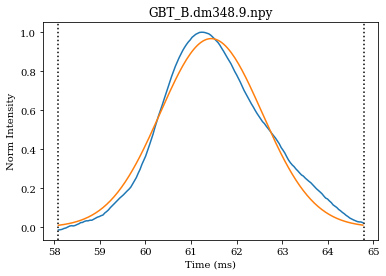

In [42]:
#Determine & Crop to Pulse Time Width
#Calculate initial guess parameters timeseries - normalized by div by max
savts = savts_2d.sum(0) / np.max(savts_2d.sum(0))
maximts = np.max(savts)
stdts = np.std(savts)
meants = np.where(savts == maximts)[0][0]
xts = np.linspace(0, len(savts), len(savts))

#Fit 1D Gaussian to Timeseries
fitterts = modeling.fitting.LevMarLSQFitter()
modelts = modeling.models.Gaussian1D(amplitude=maximts, mean=meants, stddev=stdts)
fitted_modelts = fitterts(modelts, xts, savts)
std_unc = np.sqrt(np.diag(fitterts.fit_info['param_cov']))[2]/fitted_modelts.stddev[0]

#RCS Fit Check
n_free = len(fitted_modelts.parameters)
N = len(xts)
rchisq = reduced_chi_square(fitted_modelts(xts), xts, savts, N, n_free)
print("Red. Chi Square: ", rchisq)

#Crop pulse to 1/2 pulse width on either side
pulsewidth = 3 * fitted_modelts.parameters[2] #3sigma
rcut = int(fitted_modelts.parameters[1] + pulsewidth)
lcut = int(fitted_modelts.parameters[1] - pulsewidth)
if rcut >= len(savts):
    rcut = len(savts)
if lcut <= 0:
    lcut = 0

#Cropped & Subbanded Dynamic Spectrum
sub_c = sub[:, lcut:rcut] 

#DIAGNOISTIC#
#plt.imshow(sub_c, aspect = 'auto')

print('Crop Time Bin Right', rcut)
print('Crop Time Bin Left', lcut)

#Burst Time Width
twidth = 2* (fitted_modelts.stddev * 3) * tres
print('Burst Time Width (ms): ' + str(twidth) + '+/-' + str(twidth*std_unc))

plt.plot(xts[lcut:rcut]*tres, savts[lcut:rcut])
plt.plot(xts[lcut:rcut]*tres, fitted_modelts(xts)[lcut:rcut])
plt.axvline(fitted_modelts.mean*tres + 3*fitted_modelts.stddev*tres, c = 'k', linestyle = 'dotted')
plt.axvline(fitted_modelts.mean*tres - 3*fitted_modelts.stddev*tres, c = 'k', linestyle = 'dotted')
plt.title(file.split('/')[-1])
plt.xlabel('Time (ms)')
plt.ylabel('Norm Intensity')
plt.show()

In [43]:
#Determine Pulse Bandwidth (& crop if desired...)
subsp_c_nonorm = sub_c.sum(1)
subsp_c = subsp_c_nonorm / np.max(subsp_c_nonorm) #normalize

#print("Sub Dyn Spec Shape: ", sub_c.shape)

savsp_c_nonorm = savsp_2d[:, lcut:rcut].sum(1)
savsp_c = savsp_c_nonorm / np.max(savsp_c_nonorm) #normalize

#Calculate initial guess parameters spectrum - normalized by div by max
maximsp = np.max(savsp_c)
stdsp = np.std(savsp_c)
meansp = np.where(savsp_c == maximsp)[0][0]
xsp = np.linspace(0, len(savsp_c), len(savsp_c))

#Fit 1D Gaussian to Spectrum
fittersp = modeling.fitting.LevMarLSQFitter()
modelsp = modeling.models.Gaussian1D(amplitude=maximsp, mean=meansp, stddev=stdsp)
fitted_modelsp = fittersp(modelsp, xsp, savsp_c)

#Fit Check
n_free = len(fitted_modelsp.parameters)
N = len(xsp)
rchisq = reduced_chi_square(fitted_modelsp(xsp), xsp, savsp_c, N, n_free)
print("Red. Chi Square: ", rchisq)

swidth = 2 * (fitted_modelsp.stddev[0] * 3) * subfres
print('Burst Spectral Width (MHz): ', swidth)
print('Burst Centroid Frequency (MHz): ', fitted_modelsp.mean[0]*subfres + (cfreq - bw/2))

#Crop Frequency (if desired -- not automatic)
dcut = 0
dbw = round(((dcut / npy.shape[0]) * bw) + (cfreq - bw//2))
ucut = 7680
ubw = round(((ucut / npy.shape[0]) * bw) + (cfreq - bw//2))

bwcut = round(ubw - dbw)
#print('Cropped Bandwidth: ' + str(bwcut) + ' MHz ' + 'between ' + str(ubw) + ' and ' + str(dbw))

cfcut = (((((ucut + dcut)/2) / npy.shape[0]) * bw) + (cfreq - bw//2))
#print('Cropped Center Frequency (MHz): ', cfcut)
#print(fitted_modelsp.stddev[0])

Red. Chi Square:  0.4695820219351504
Burst Spectral Width (MHz):  342.7924349647876
Burst Centroid Frequency (MHz):  818.4872486521919


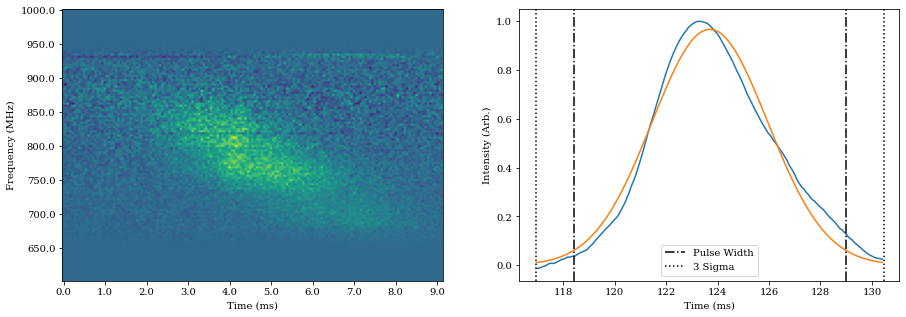

In [60]:
#Frequency
flabellocs = np.arange(0, sub_c.shape[0], step=sub_c.shape[0]//((2*bw/100)))
flabel_noend = np.arange(cfreq - bw/2, cfreq+ bw/2, step=bw//((2*bw/100)))
flabels = np.flip(np.append(flabel_noend, [cfreq+ bw/2]))

#Time
tbin = sub.shape[1]
tres = 0.08192 #ms
tlabellocs = np.arange(0, sub_c.shape[1], step=sub_c.shape[1]//(8+1))
tlabels_noend = np.arange(0, sub_c.shape[1]*tres, step=(sub_c.shape[1]*tres)//8)
tlabels = np.append(tlabels_noend, [int(sub_c.shape[1]*tres)])

#Plot
fig = plt.figure(figsize = (15, 5))
ax = fig.add_subplot(121)
plt.imshow(sub_c, aspect = 'auto')
plt.xticks(tlabellocs, tlabels)
plt.yticks(flabellocs, flabels)
plt.ylabel('Frequency (MHz)')
plt.xlabel('Time (ms)')
fig.add_subplot(122)
plt.plot(xts[lcut:rcut]*tres, savts[lcut:rcut])
plt.plot(xts[lcut:rcut]*tres, fitted_modelts(xts)[lcut:rcut])
plt.axvline(fitted_modelts.mean*tres + 2.355*fitted_modelts.stddev*tres, c = 'k', linestyle = 'dashdot', label = 'Pulse Width')
plt.axvline(fitted_modelts.mean*tres - 2.355*fitted_modelts.stddev*tres, c = 'k', linestyle = 'dashdot')
plt.axvline(fitted_modelts.mean*tres + 3*fitted_modelts.stddev*tres, c = 'k', linestyle = 'dotted', label = '3 Sigma')
plt.axvline(fitted_modelts.mean*tres - 3*fitted_modelts.stddev*tres, c = 'k', linestyle = 'dotted')
plt.ylabel('Intensity (Arb.)')
plt.xlabel('Time (ms)')
plt.legend()
plt.show()

In [72]:
#Crop Smoothed Dyn Spec on Both Axes
savts_2d_c = savts_2d[:, lcut:rcut]
savsp_2d_c = savsp_2d[:, lcut:rcut]

#Calculate 2d acf
acf2d = ss.correlate(savts_2d_c, savsp_2d_c)

#Cap spiked central values in acf
cap = np.mean(acf2d[len(acf2d.sum(1))//2 +10:len(acf2d.sum(1))//2 +10, len(acf2d.sum(0))//2 +10:len(acf2d.sum(0))//2 +10])
acf2d_cap = np.where(acf2d > cap, cap, acf2d)

#Smooth Data w Savitzky Golay filter (t - time) (s - spectrum)
twinlen = acf2d.shape[1] // 4
if twinlen % 2 == 0:
    twinlen = twinlen + 1
swinlen = acf2d.shape[0] // 4
if swinlen % 2 == 0:
    swinlen = swinlen + 1
polyo = 6
savacft = ss.savgol_filter(acf2d, twinlen, polyo, axis=1)
savacff = ss.savgol_filter(acf2d, swinlen, polyo, axis=0)
print('ACF Time Window Length: ', twinlen)
print('ACF Freq Window Length: ', swinlen)

#Calculate initial guess parameters spectrum acf time
savt = savacft.sum(0) / np.max(savacft.sum(0))
maximt = np.max(savt)
stdt = np.std(savt)
meant = np.where(savt == maximt)[0][0]
xt = np.linspace(0, len(savt), len(savt))

#Fit 1D Gaussian to Spectrum
fittert = modeling.fitting.LevMarLSQFitter()
modelt = modeling.models.Gaussian1D(amplitude=maximt, mean=meant, stddev=stdt)
fitted_modelt = fittert(modelt, xt, savt)

#Calculate initial guess parameters spectrum acf freq
savsp = savacff.sum(1) / np.max(savacff.sum(1))
maximsp = np.max(savsp)
stdsp = np.std(savsp)
meansp = np.where(savsp == maximsp)[0][0]
xsp = np.linspace(0, len(savsp), len(savsp))

#Fit 1D Gaussian to Spectrum
fittersp = modeling.fitting.LevMarLSQFitter()
modelsp = modeling.models.Gaussian1D(amplitude=maximsp, mean=meansp, stddev=stdsp)
fitted_modelsp = fittersp(modelsp, xsp, savsp)

#Get Ellipse Ratio
sigmat = fitted_modelt.stddev.value * (2.355/2)
sigmaf = fitted_modelsp.stddev.value * (2.355/2)

#Sigmas form a rectangle, get slope of the rectangle diagonal to estimate semi major axis PA
hyp = np.sqrt(sigmat**2 + sigmaf**2)
estpa = np.arccos(sigmat / hyp) #in radians

#Estimate ellipticity (eps) with sigma ratio
oppestpa = np.arccos(sigmaf / hyp)
estsmajax = np.tan(oppestpa)*(hyp / 2)
estsminax = hyp / 4
esteps = 1 - (estsminax / estsmajax)

print(estsmajax, estsminax)

print('Estimated Ellipticity: ', esteps)
print('Estmated Semimajor Axis: ', estsmajax)
print('Estimated PA: ', estpa)

ACF Time Window Length:  83
ACF Freq Window Length:  63
43.56854636011153 13.739673547256519
Estimated Ellipticity:  0.6846423694356796
Estmated Semimajor Axis:  43.56854636011153
Estimated PA:  0.5626986133326142


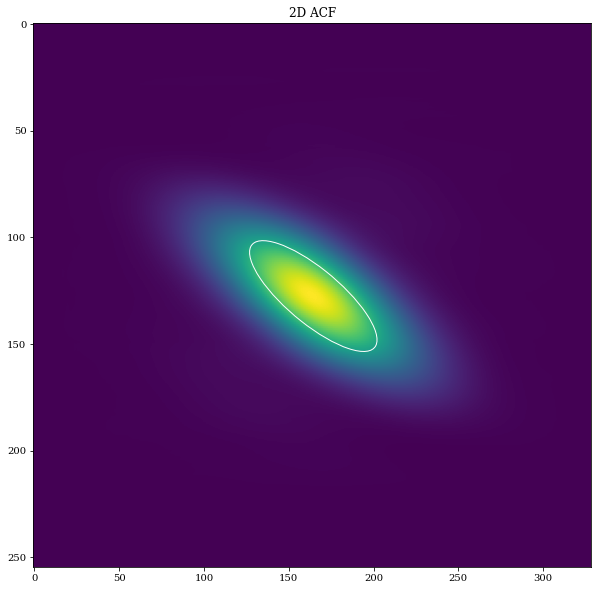

In [73]:
#Provide the initial ellipse to be fitted
#Calculate ellipse geometry
geometry = EllipseGeometry(x0 = acf2d.shape[1]/2, \
            y0 = acf2d.shape[0]/2, sma = estsmajax, eps = esteps, pa = estpa)
#Show initial guess ellipse
aper = EllipticalAperture((geometry.x0, geometry.y0), \
            geometry.sma, geometry.sma*(1-geometry.eps),geometry.pa)

fig = plt.figure(figsize = (10, 10))
plt.imshow(acf2d, aspect = 'auto')
#plt.ylabel('Frequency (MHz)')
#plt.xlabel('Time (ms)')
plt.title('2D ACF')
aper.plot(color='white')

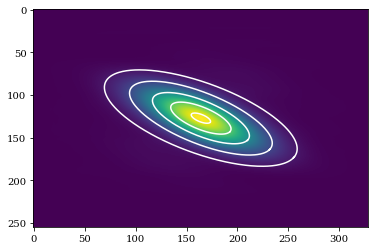

In [75]:
#Fit ellipse to 2d acf
try:
    ellipse = Ellipse(acf2d, geometry)
    isolist = ellipse.fit_image()
    model_image = build_ellipse_model(acf2d.shape, isolist)
    residual = acf2d - model_image
    
    smas = np.linspace(10, 100, 5)
    for sma in smas:
        iso = isolist.get_closest(sma)
        x, y, = iso.sampled_coordinates()
        plt.imshow(acf2d, aspect = 'auto')
        plt.plot(x, y, color='white')
except OverflowError:
    print('Note: Overflow Error')
    pass
except ValueError:
    print('Note: Value Error')
    pass
except IndexError:
    print('Ellipse Fit Failed!')
    pass

DYN Time Window Length 513
DYN Freq Window Length 121
Crop Time Bin Right 283
Crop Time Bin Left 0
Frequency Resolution 0.1953125 MHz
Sub Frequency Resolution 3.125 MHz


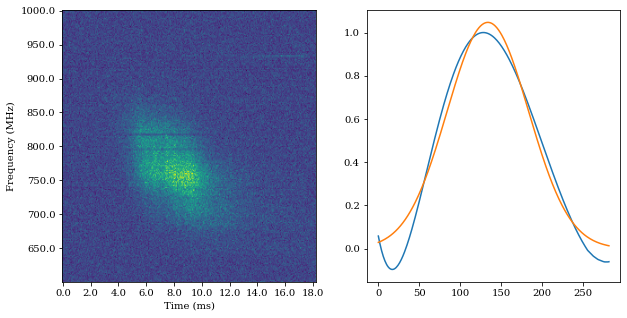

In [329]:
#Sub-band data
subfac = 16
sub = rb_sub = np.nanmean(b.reshape(-1, subfac, b.shape[1]), axis=1)

#Smooth Data w Savitzky Golay filter (t - time) (s - spectrum)
twinlen = sub.shape[1] // 4
if twinlen % 2 == 0:
    twinlen = twinlen + 1
swinlen = sub.shape[0] // 2
if swinlen % 2 == 0:
    swinlen = swinlen + 1
polyo = 6
savts_2d = ss.savgol_filter(sub, twinlen, polyo, axis=1)
savsp_2d = ss.savgol_filter(sub, swinlen, polyo, axis=0)
print('DYN Time Window Length', twinlen)
print('DYN Freq Window Length', swinlen)

#Calculate initial guess parameters timeseries - normalized by div by max
savts = savts_2d.sum(0) / np.max(savts_2d.sum(0))
maximts = np.max(savts)
stdts = np.std(savts)
meants = np.where(savts == maximts)[0][0]
xts = np.linspace(0, len(savts), len(savts))

#Fit 1D Gaussian to Timeseries
fitterts = modeling.fitting.LevMarLSQFitter()
modelts = modeling.models.Gaussian1D(amplitude=maximts, mean=meants, stddev=stdts)
fitted_modelts = fitterts(modelts, xts, savts)

#Crop pulse to 1/2 pulse width on either side
pulsewidth = 3 * fitted_modelts.parameters[2] #3sigma
rcut = int(fitted_modelts.parameters[1] + pulsewidth)
lcut = int(fitted_modelts.parameters[1] - pulsewidth)
if rcut >= len(savts):
    rcut = len(savts)
if lcut <= 0:
    lcut = 0
    
print('Crop Time Bin Right', rcut)
print('Crop Time Bin Left', lcut)
sav_c = sub[:, lcut:rcut]

#Apply proper units to axes
nchan = b.shape[1]
bw = 400 #MHz
cfreq = 800 #MHz
fres = bw / nchan
print('Frequency Resolution', str(fres) + ' MHz')
subchan = nchan / subfac
subfres = bw / subchan
print('Sub Frequency Resolution', str(subfres) + ' MHz')

#Frequency
flabellocs = np.arange(0, sav_c.shape[0], step=sav_c.shape[0]//((2*bw/100)))
flabel_noend = np.arange(cfreq - bw/2, cfreq+ bw/2, step=bw//((2*bw/100)))
flabels = np.flip(np.append(flabel_noend, [cfreq+ bw/2]))

#Time
tbin = sav_c.shape[1]
tres = 0.08192 #ms
tlabellocs = np.arange(0, sav_c.shape[1], step=sav_c.shape[1]//(8+1))
tlabels_noend = np.arange(0, sav_c.shape[1]*tres, step=(sav_c.shape[1]*tres)//8)
tlabels = np.append(tlabels_noend, [int(sav_c.shape[1]*tres)])

#Plot
fig = plt.figure(figsize = (10, 5))
ax = fig.add_subplot(121)
plt.imshow(sav_c, aspect = 'auto')
plt.xticks(tlabellocs, tlabels)
plt.yticks(flabellocs, flabels)
plt.ylabel('Frequency (MHz)')
plt.xlabel('Time (ms)')
fig.add_subplot(122)
plt.plot(xts[lcut:rcut], savts[lcut:rcut])
plt.plot(xts[lcut:rcut], fitted_modelts(xts)[lcut:rcut])
plt.show()

TypeError: Invalid shape (1919,) for image data

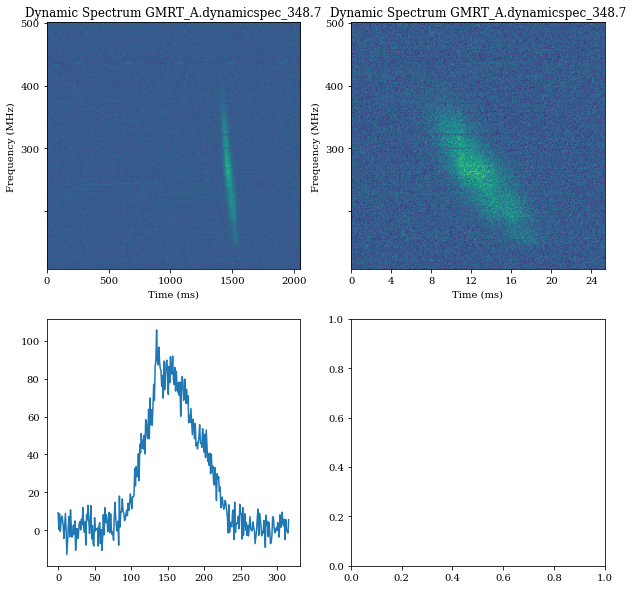

In [143]:
fig = plt.figure(figsize = (10, 10))

ax1 = fig.add_subplot(221)
plt.imshow(sub, interpolation = None, aspect = 'auto')
plt.yticks(np.arange(0, sav_c.shape[0], 61), [500, 400, 300])
#plt.xticks(np.arange(0, sub.shape[1], 239), [0, 10, 20, 30, 40, 50, 60, 70, 80])
plt.ylabel('Frequency (MHz)')
plt.xlabel('Time (ms)')
plt.title('Dynamic Spectrum GMRT_A.dynamicspec_348.7')


ax2 = fig.add_subplot(222)
plt.imshow(sav_c, aspect = 'auto')
plt.yticks(np.arange(0, sav_c.shape[0], 61), [500, 400, 300])
plt.xticks(np.arange(0, sav_c.shape[1], 50), np.arange(0, 40, 4))
plt.ylabel('Frequency (MHz)')
plt.xlabel('Time (ms)')
plt.title('Dynamic Spectrum GMRT_A.dynamicspec_348.7')
#x1 = np.linspace(0, 100 , 100)
#def y(x):
#    return (0.85) * x + 37
#y1 = y(x1)
##print(y1)
#plt.plot(x1, y1, c = 'w')
#print(np.max(isolist.pa))

ax3 = fig.add_subplot(223)
plt.plot(sav_c.sum(0))

ax4 = fig.add_subplot(224)
plt.imshow(acf, aspect = 'auto')
plt.yticks(np.arange(0, acf.shape[0], 49), np.arange(-1000, 1000, 200))
plt.xticks(np.arange(0, sav_c.shape[1], 50), np.arange(0, 40, 4))
smas = np.linspace(10, 100, 4)
for sma in smas:
    iso = isolist.get_closest(sma)
    x, y, = iso.sampled_coordinates()
    plt.plot(x, y, color='white')
plt.ylabel('Frequency (MHz)')
plt.xlabel('Time (ms)')
plt.title('2D ACF GMRT_A.dynamicspec_348.7')
print(np.tan(np.max(isolist.pa)))



plt.tight_layout()
plt.show()
fig.savefig('GMRT_A.dynamicspec_348.7_fourplot.png')

In [ ]:
peaks = ss.find_peaks(savts)
proms = ss.peak_prominences(savts, peaks[0])
widths = ss.peak_widths(subts, peaks[0])[0]
pulsepk = np.int(np.where(proms == np.max(proms[0]))[1][0])
pulsewd = widths[pulsepk]

[299]
281.97317774486874
Decorrelation Bandwidth:  200.06770329222482 MHz


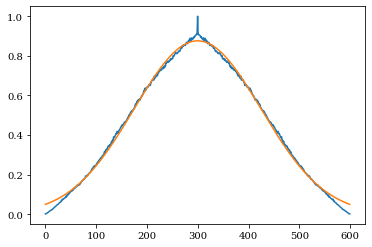

In [151]:
#Calculate initial guess parameters timeseries - normalized by div by max
subf = bb.sum(1)

acf = ss.correlate(subf, subf)

#acff = ss.savgol_filter(acf, len(acf)//2, 6)
acff_norm = acf / np.max(acf)
#plt.plot(acff_norm[800:1200])

maximf_acf = np.max(acff_norm)
#print(maximts_acf)
stdf_acf = np.std(acff_norm)
#print(stdf_acf)
meanf_acf = np.where(acff_norm == maximf_acf)[0][0]
#print(meants_acf)
xf_acf = np.linspace(0, len(acff_norm), len(acff_norm))

#Fit 1D Gaussian to Timeseries
fitterf_acf = modeling.fitting.LevMarLSQFitter()
modelf_acf = modeling.models.Gaussian1D(amplitude=maximf_acf, mean=meanf_acf, stddev=stdf_acf)
fitted_modelf_acf = fitterf_acf(modelf_acf, xf_acf, acff_norm)
fit_f = fitted_modelf_acf(xf_acf)

plt.plot(xf_acf[:], acff_norm[:])
plt.plot(xf_acf[:], fit_f[:])

peaks = ss.find_peaks(fit_f)[0]
print(peaks)
peak_widths = ss.peak_widths(fit_f, peaks)[0][0]
print(peak_widths)
decor_bw = peak_w * subfres
print('Decorrelation Bandwidth: ', str(decor_bw) + ' MHz' )

In [145]:
subfac = 16
xhi = 1000
xlo = 500

sub = rb_sub = np.nanmean(D.reshape(-1, subfac, D.shape[1]), axis=1)
sav = ss.savgol_filter(sub, 69, 6)
sav_c = sav[:, xlo:xhi]

fig = plt.figure(figsize = (5, 5))
plt.imshow(sav_c, aspect = 'auto', interpolation = None)
plt.ylabel('Frequency Channels')
plt.xlabel('Time Bins')
plt.title('Dynamic Spectrum GMRT A')
fig.savefig('GBT_B_dynspec.png')

NameError: name 'D' is not defined

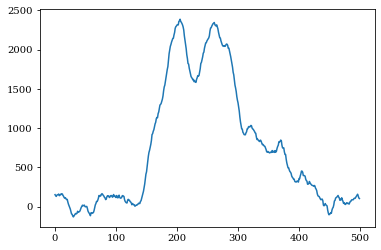

In [160]:
plt.plot(sav_c.sum(0))

[489 490 491 492 493 494 495 496 497 498 499 500 501 502 503 504 505 506
 507 508]


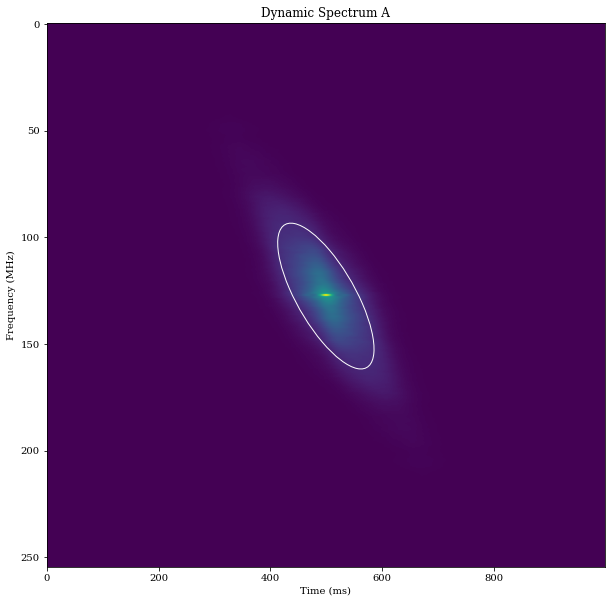

In [151]:
#Calculate 2D ACF
acf = ss.correlate(sav_c, sav_c)
acf = acf ** (2)

print(np.arange(int((len(acf.sum(0)))/2 - 10), int(len(acf.sum(0))/2 + 10)))

#Mask acf to eliminate peakiness
#acf[len(acf.sum(1))//2 -1 : len(acf.sum(1))//2 +1, len(acf.sum(0))//2 -10:len(acf.sum(0))//2 +10] \
#    = np.ones(len(acf.sum(0)))*np.mean(acf[len(acf.sum(1))//2 +1:len(acf.sum(1))//2 +5, len(acf.sum(0))//2 -10:len(acf.sum(0))//2 +10])

#Cap acf values
#cap = np.mean(acf[len(acf.sum(1))//2 +1:len(acf.sum(1))//2 +2, len(acf.sum(0))//2 +10:len(acf.sum(0))//2 +20])
#acf[acf > cap] = cap


#Ellipse Parameters
sma = 90 #semi-major axis
eps = 0.75 #ellipticity 
pa = 0.3 #position angle

#Provide the initial Ellipse to be fitted
#Calculate Ellipse Geometry
geometry = EllipseGeometry(x0 = acf.shape[1]/2, \
            y0 = acf.shape[0]/2, sma = sma, eps = eps, pa = pa)
#Show Initial Guess Ellipsee
aper = EllipticalAperture((geometry.x0, geometry.y0), \
            geometry.sma, geometry.sma*(1-geometry.eps),geometry.pa)

#Plot Initial Guess Ellipse on ACF
fig = plt.figure(figsize = (10, 10))
plt.imshow(acf, aspect = 'auto')
plt.ylabel('Frequency (MHz)')
plt.xlabel('Time (ms)')
plt.title('Dynamic Spectrum A')
aper.plot(color='white')
#fig.savefig('A.png')

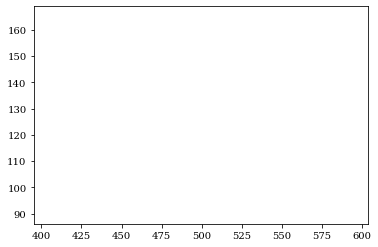

In [143]:
#Fit Ellipse to 2D ACF
try:
    ellipse = Ellipse(acf, geometry)
    isolist = ellipse.fit_image()
    model_image = build_ellipse_model(acf.shape, isolist)
    residual = acf - model_image
    
    smas = np.linspace(10, 100, 5)
    for sma in smas:
        iso = isolist.get_closest(sma)
        x, y, = iso.sampled_coordinates()
        plt.plot(x, y, color='white')
except OverflowError:
    print('Note: Overflow Error')
    pass
except ValueError:
    print('Note: Value Error')
    pass
except IndexError:
    print('Ellipse Fit Failed!')
    pass

0.3093362496096232


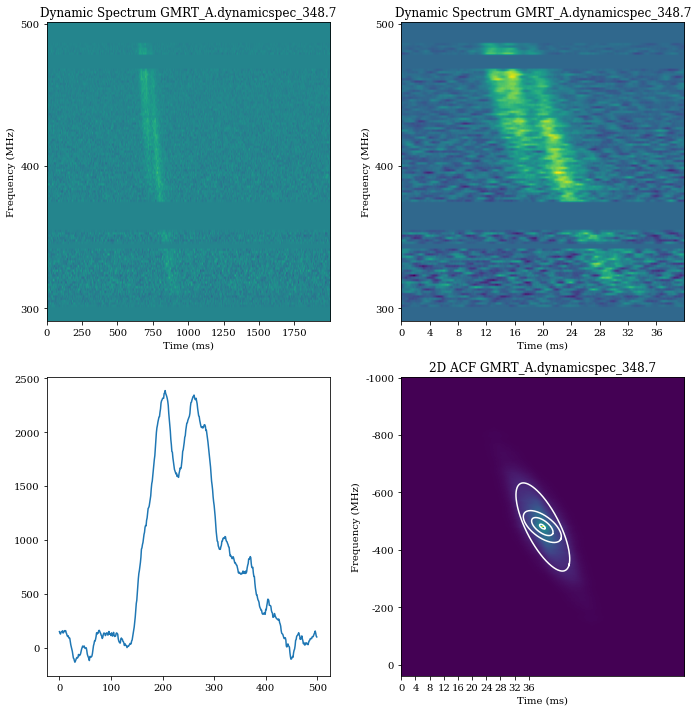

In [156]:
fig = plt.figure(figsize = (10, 10))

ax1 = fig.add_subplot(221)
plt.imshow(sub, interpolation = None, aspect = 'auto')
plt.yticks(np.arange(0, sav_c.shape[0], 61), [500, 400, 300])
#plt.xticks(np.arange(0, sub.shape[1], 239), [0, 10, 20, 30, 40, 50, 60, 70, 80])
plt.ylabel('Frequency (MHz)')
plt.xlabel('Time (ms)')
plt.title('Dynamic Spectrum GMRT_A.dynamicspec_348.7')


ax2 = fig.add_subplot(222)
plt.imshow(sav_c, aspect = 'auto')
plt.yticks(np.arange(0, sav_c.shape[0], 61), [500, 400, 300])
plt.xticks(np.arange(0, sav_c.shape[1], 50), np.arange(0, 40, 4))
plt.ylabel('Frequency (MHz)')
plt.xlabel('Time (ms)')
plt.title('Dynamic Spectrum GMRT_A.dynamicspec_348.7')
#x1 = np.linspace(0, 100 , 100)
#def y(x):
#    return (0.85) * x + 37
#y1 = y(x1)
##print(y1)
#plt.plot(x1, y1, c = 'w')
#print(np.max(isolist.pa))

ax3 = fig.add_subplot(223)
plt.plot(sav_c.sum(0))

ax4 = fig.add_subplot(224)
plt.imshow(acf, aspect = 'auto')
plt.yticks(np.arange(0, acf.shape[0], 49), np.arange(-1000, 1000, 200))
plt.xticks(np.arange(0, sav_c.shape[1], 50), np.arange(0, 40, 4))
smas = np.linspace(10, 100, 4)
for sma in smas:
    iso = isolist.get_closest(sma)
    x, y, = iso.sampled_coordinates()
    plt.plot(x, y, color='white')
plt.ylabel('Frequency (MHz)')
plt.xlabel('Time (ms)')
plt.title('2D ACF GMRT_A.dynamicspec_348.7')
print(np.tan(np.max(isolist.pa)))



plt.tight_layout()
plt.show()
fig.savefig('GMRT_A.dynamicspec_348.7_fourplot.png')